# Model Zoo

### 1. Persistence
- `Pers1` : observation from day before at the same time of day (no diurnal, seasonal correction)
- `Pers2` : observation from Morning + diurnal correction

In [368]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime

from matplotlib import pyplot as plt

from scipy.stats import probplot, cumfreq

from statsmodels.distributions.empirical_distribution import ECDF

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

import properscoring as ps

## Implementation of PP-Plot, PP-plot Metric & Sanity Check

In [539]:
def ppPlot(y_obs, mu_hat, sigma_hat, comment="-"): 
    # '''Computes the PP-plot metric based on conditional Gaussiantiy, provided arrays of aobservations, mu, and sigma estimates'''
    assert len(y_obs)==len(mu_hat), "Observations and expected value lists/arrays must have same length."
    sigma_hat = [sigma_hat]*len(y_obs) if (isinstance(sigma_hat, float) or isinstance(sigma_hat, int)) else sigma_hat
    assert len(mu_hat)==len(sigma_hat), "Expected value and sigma lists/arrays must have same length."

    # sort dist. parameters accordingly (w.r.t. observation size)
    mu_hat    = [x for _, x in sorted(zip(y_obs, mu_hat))]
    sigma_hat = [x for _, x in sorted(zip(y_obs, sigma_hat))]
    # sort observations
    y_obs = sorted(y_obs)

    # F: empirical. CDF
    empCDF = ECDF(y_obs)
    F_ = empCDF(y_obs)

    # G: predicted, conditional CDF
    G_ = np.array([norm.cdf(_, loc=meanLoc, scale=sigmaLoc) for (_, meanLoc, sigmaLoc) in zip(y_obs, mu_hat, sigma_hat)])


    plt.suptitle('PP-Plot (n={})'.format(len(y_obs)), fontsize=18, y=1.0175)
    plt.title(comment, fontsize=15)
    plt.plot([0,1], [0,1], 'r-', zorder=1)
    plt.scatter(F_, G_, zorder=2)
    plt.show()
    
    
def ppMetric(y_obs, mu_hat, sigma_hat, comment="-"): 
    # '''Computes the PP-plot metric based on conditional Gaussiantiy, provided arrays of aobservations, mu, and sigma estimates'''
    assert len(y_obs)==len(mu_hat), "Observations and expected value lists/arrays must have same length."
    sigma_hat = [sigma_hat]*len(y_obs) if (isinstance(sigma_hat, float) or isinstance(sigma_hat, int)) else sigma_hat
    assert len(mu_hat)==len(sigma_hat), "Expected value and sigma lists/arrays must have same length."

    # sort dist. parameters accordingly (w.r.t. observation size)
    mu_hat    = [x for _, x in sorted(zip(y_obs, mu_hat))]
    sigma_hat = [x for _, x in sorted(zip(y_obs, sigma_hat))]
    # sort observations
    y_obs = sorted(y_obs)

    # F: empirical. CDF
    empCDF = ECDF(y_obs)
    F_ = empCDF(y_obs)

    # G: predicted, conditional CDF
    G_ = np.array([norm.cdf(_, loc=meanLoc, scale=sigmaLoc) for (_, meanLoc, sigmaLoc) in zip(y_obs, mu_hat, sigma_hat)])


    plt.suptitle('PP-Plot (n={})'.format(len(y_obs)), fontsize=18, y=1.0175)
    plt.title(comment, fontsize=15)
    plt.plot([0,1], [0,1], 'r-', zorder=1)
    plt.scatter(F_, G_, zorder=2)
    plt.show()
   

In [540]:
# PP Plot Metric

# DEBUG: example
N = 1000
rnd = np.random.normal(loc=2, scale=2, size=N)
mus = [2]*N
sig = 2

# rename 

# sort dist. parameters accordingly (w.r.t. observation size)
mu_hat    = [x for _, x in sorted(zip(y_obs, mu_hat))]
sigma_hat = [x for _, x in sorted(zip(y_obs, sigma_hat))]
# sort observations
y_obs = sorted(y_obs)

# F: empirical. CDF
empCDF = ECDF(y_obs)
F_ = empCDF(y_obs)

# G: predicted, conditional CDF
G_ = np.array([norm.cdf(_, loc=meanLoc, scale=sigmaLoc) for (_, meanLoc, sigmaLoc) in zip(y_obs, mu_hat, sigma_hat)])


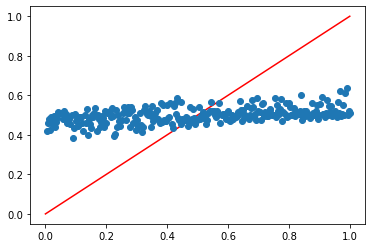

In [543]:
    plt.plot([0,1], [0,1], 'r-', zorder=1)
    plt.scatter(F_, G_, zorder=2)
    plt.show()

### Sanity-check the PP-plot methods

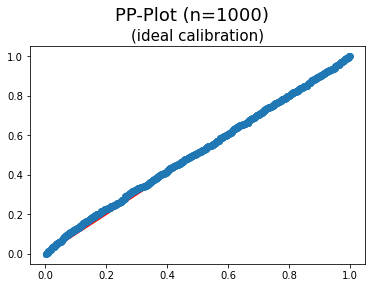

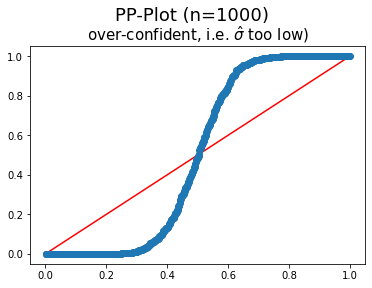

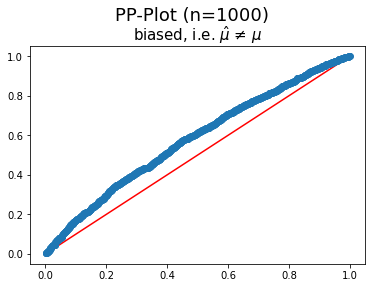

In [535]:

# A. Calibrated
N = 1000
rnd = np.random.normal(loc=2, scale=2, size=N)
mus = [2]*N
sig = 2
ppPlot(rnd, mus, sig, "(ideal calibration)")

# B. Over-confident
rnd = np.random.normal(loc=2, scale=2, size=N)
mus = [2]*N
sig = 0.5
ppPlot(rnd, mus, sig, "over-confident, i.e. $\hat{\sigma}$ too low)")

# C. Biased
rnd = np.random.normal(loc=2, scale=2, size=N)
mus = [1.5]*N
sig = 2
ppPlot(rnd, mus, sig, "biased, i.e. $\hat{\mu}$ ≠ $\mu$")

## Load & split Data: *Train*, *Val* and *Test*

In [308]:
# load data
df    = pd.read_csv('df.csv', parse_dates=['date'])
df_ts = pd.read_csv('df_ts.csv', parse_dates=['date'])

# delete NaN's
df    = df[df['Y'] != -999]
df_ts = df_ts[df_ts['Y'] != -999]

# add day of the year (DoY)
df['DoY'] = df['date'].dt.dayofyear.map(lambda x : np.sin((2*np.pi*x) / (365.0)))

X, y = df.drop(labels=['date', 'Y'], axis=1).to_numpy(), df['Y'].to_numpy()

# regression split (LASSO, ...)
seed_1, seed_2 = 5645, 8373
X_tr, X_, y_tr, y_     = train_test_split(X,  y,  train_size=280, random_state=seed_1) #  train: 280
X_te, X_va, y_te, y_va = train_test_split(X_, y_, train_size=60,  random_state=seed_2) # "test" : 60  -> val: 59

# time series split (...)
lTr   = datetime.strptime('2021-10-07 12:00:00', '%Y-%m-%d %H:%M:%S') # 280
lVa   = datetime.strptime('2021-12-06 12:00:00', '%Y-%m-%d %H:%M:%S') # 60
lTe   = datetime.strptime('2022-03-23 12:00:00', '%Y-%m-%d %H:%M:%S') # 59`

## 1. `Pers` 
Observation from previous day (same time of the day, i.e. noon) as $\hat{\mu}_{t}$. Same (estimated) variance across year, i.e. $\hat{\sigma}^{2}$. Gaussianity as the assumed conditional distribution for probabilistic prediction, i.e. 
$$ Y_{t+1} \sim \mathcal{N}(Y_{t}, \hat{\sigma}^{2}) $$

In [314]:
# train mu
pers1_tr_mu = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date <= lTr)]['Y'].shift(1).fillna(131.9).to_numpy()
Y_tr        = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date <= lTr)]['Y'].to_numpy()

# check variance
CRPS_list = []
sigma_list = np.linspace(15, 300, 500)
for sigmaLoc in sigma_list:
    CRPS_list.append(np.mean(ps.crps_gaussian(Y_tr, mu=pers1_tr_mu, sig=sigmaLoc)))
    
# optimal sigma
sigma_pers1_hat = sigma_list[list(CRPS_list == min(CRPS_list)).index(True)]

# CRPS: Train Set
# - train
CRPS_pers1_tr = np.mean(ps.crps_gaussian(Y_tr, mu=pers1_tr_mu, sig=sigma_pers1_hat))


In [513]:
%%time
# para
mu_hat = pers1_tr_mu
y_obs = Y_tr

def ppPlot(y_obs, mu_hat, sigma_hat, comment="-"): 
    # '''Computes the PP-plot metric based on conditional Gaussiantiy, provided arrays of aobservations, mu, and sigma estimates'''
    assert len(y_obs)==len(mu_hat), "Observations and expected value lists/arrays must have same length."
    sigma_hat = [sigma_hat]*len(y_obs) if (isinstance(sigma_hat, float) or isinstance(sigma_hat, int)) else sigma_hat
    assert len(mu_hat)==len(sigma_hat), "Expected value and sigma lists/arrays must have same length."

    # sort dist. parameters accordingly (w.r.t. observation size)
    mu_hat    = [x for _, x in sorted(zip(y_obs, mu_hat))]
    sigma_hat = [x for _, x in sorted(zip(y_obs, sigma_hat))]
    # sort observations
    y_obs = sorted(y_obs)

    # F: empirical. CDF
    empCDF = ECDF(y_obs)
    F_ = empCDF(y_obs)

    # G: predicted, conditional CDF
    G_ = np.array([norm.cdf(_, loc=meanLoc, scale=sigmaLoc) for (_, meanLoc, sigmaLoc) in zip(y_obs, mu_hat, sigma_hat)])


    plt.suptitle('PP-Plot (n={})'.format(len(y_obs)), fontsize=18, y=1.0175)
    plt.title(comment, fontsize=15)
    plt.plot([0,1], [0,1], 'r-', zorder=1)
    plt.scatter(F_, G_, zorder=2)
    plt.show()


CPU times: user 11 µs, sys: 1 µs, total: 12 µs
Wall time: 16.2 µs


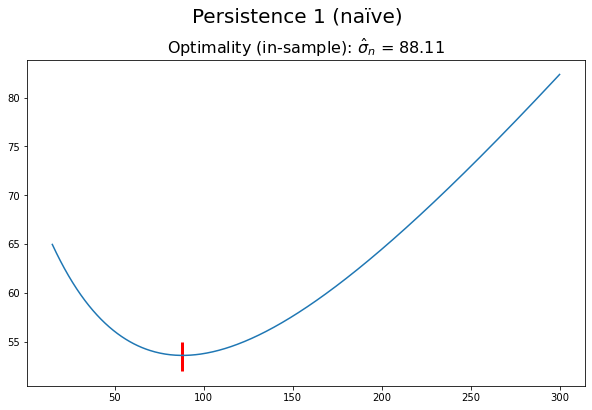

In [251]:
# Visualize optimal standard deviation
plt.figure(figsize=(10,6))
plt.suptitle("Persistence 1 (naïve)", fontsize=20, y=1.002)
plt.title("Optimality (in-sample): $\hat{\sigma}_{n}$ = " + str(round(sigma_pers1_hat, 2)), fontsize=16)
plt.plot(sigma_list, CRPS_list)
plt.vlines(x=sigma_pers1_hat, ymin=52, ymax=55, color='red', linewidth=3)

plt.show()

In [252]:
# Validation Set
pers1_va_mu = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date > lTr) & (df_ts.date <= lVa)]['Y'].shift(1).fillna(131.9).to_numpy()
Y_tr        = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date > lTr) & (df_ts.date <= lVa)]['Y'].to_numpy()
# - val
CRPS_pers1_val = np.mean(ps.crps_gaussian(Y_tr, mu=pers1_va_mu, sig=sigma_pers1_hat))

# Test Set
pers1_te_mu = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date > lVa)]['Y'].shift(1).fillna(131.9).to_numpy()
Y_tr        = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date > lVa)]['Y'].to_numpy()
# - test
CRPS_pers1_test = np.mean(ps.crps_gaussian(Y_tr, mu=pers1_te_mu, sig=sigma_pers1_hat))


In [247]:
CRPS_pers1_test

46.80056999426133

<AxesSubplot:>

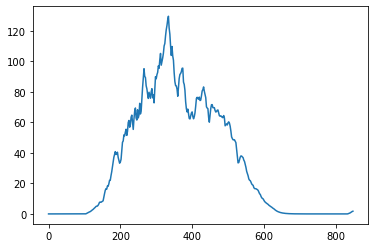

In [72]:
df_ts[df_ts['date'].dt.hour == 6]['Y'].ewm(span = 14).mean().plot()

<AxesSubplot:>

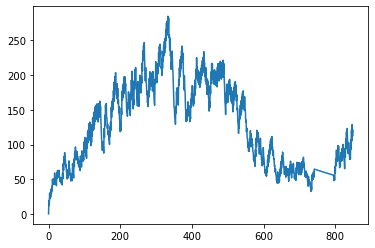

In [58]:
df_ts['Y'].ewm(span = 14).mean().plot() #.ewm()

<AxesSubplot:>

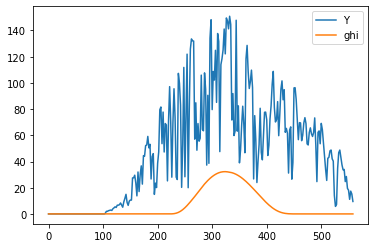

In [42]:
# 1. Persistence
#mu_pers = 
df_ts[(df_ts.date <= lTr) & (df_ts.date.dt.hour==6)][['Y', 'ghi']].plot()
#df_ts[(df_ts.date <= lTr) & (df_ts.date.dt.hour==12)]['Y'].plot()  #[['date', 'Y']] #['Y'].shift(1)

<AxesSubplot:>

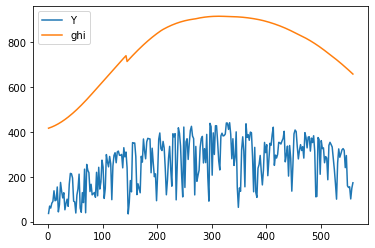

In [43]:
df_ts[(df_ts.date <= lTr) & (df_ts.date.dt.hour==12)][['Y', 'ghi']].plot()

## Cubic Spline

In [35]:
df_ts['Y'].interpolate(method='cubic')

0        0.00
1       36.38
2        0.00
3       69.20
4        0.00
        ...  
887   -999.00
888   -999.00
889   -999.00
890   -999.00
891   -999.00
Name: Y, Length: 892, dtype: float64

In [37]:
df_ts['Y']

0        0.00
1       36.38
2        0.00
3       69.20
4        0.00
        ...  
887   -999.00
888   -999.00
889   -999.00
890   -999.00
891   -999.00
Name: Y, Length: 892, dtype: float64

,date,Y,ghi,dni,dhi
0,2021-01-01 06:00:00,0.00,0.000000,0.000000,0.000000
1,2021-01-01 12:00:00,36.38,416.085586,862.558605,48.835440
2,2021-01-02 06:00:00,0.00,0.000000,0.000000,0.000000
3,2021-01-02 12:00:00,69.20,417.747096,862.704615,49.157413
4,2021-01-03 06:00:00,0.00,0.000000,0.000000,0.000000
...,...,...,...,...,...
845,2022-02-27 12:00:00,297.30,662.491114,903.729846,81.870280
846,2022-02-28 06:00:00,3.55,0.000000,0.000000,0.000000
847,2022-02-28 12:00:00,283.73,667.998271,903.907716,82.698714
848,2022-03-01 06:00:00,3.02,0.000000,0.000000,0.000000
